In [1]:
%matplotlib notebook

In [2]:
import glob
import numpy as np
from readts import TSFile
import matplotlib.pyplot as plt
from ase import io
from soprano.utils import minimum_periodic

In [10]:
tsf = TSFile('CuVacMorse', 'cuvac-neb-morse')

In [15]:
tstb = tsf.blocks['TST']

In [24]:
tstb.get_energies(10)*27.2114

array([6153.45108188, 6137.50043948, 6135.90873585, 6137.49970478,
       6153.45004785])

In [63]:
class TSTrajectory(object):
    
    def __init__(self, name='CASTEP'):
        # Find the structure files
        files = sorted(glob.glob('outputs/CuVac-{}-*.cell'.format(name)))
        # Load them
        self.structs = [io.read(f) for f in files]
        # Energies?
        self.energies = np.loadtxt('outputs/CuVac-{}-E.dat'.format(name))
        self.energies -= self.energies[0]
        # Reaction coordinates?
        pos = [a.positions for a in self.structs]
        dpos = np.diff(pos, axis=0)
        shape = dpos.shape
        cell = self.structs[0].cell
        dpos = minimum_periodic(dpos.reshape((-1,3)), cell)[0].reshape(shape)
        r = np.linalg.norm(dpos, axis=(1,2))
        rcoords = np.concatenate([[0], np.cumsum(r)])
        self.rcoords = rcoords/rcoords[-1]
    
    @property
    def positions(self):
        return np.array([s.positions for s in self.structs])

In [64]:
cst_tst = TSTrajectory('CASTEP')
ase_tst = TSTrajectory('ASE')
skt_tst = TSTrajectory('SOCKET')

<IPython.core.display.Javascript object>


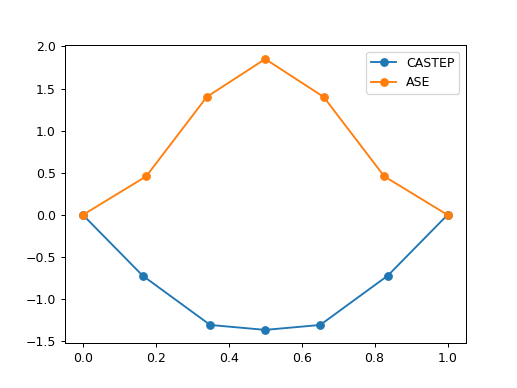

In [6]:
fig, ax = plt.subplots()

ax.plot(cst_tst.rcoords, cst_tst.energies, 'o-', label='CASTEP')
ax.plot(ase_tst.rcoords, ase_tst.energies, 'o-', label='ASE')

ax.legend()

In [28]:
cst_tst.energies

array([ 0.00000000e+00, -7.20924000e-01, -1.30709900e+00, -1.36559300e+00,
       -1.30712600e+00, -7.20962000e-01,  6.00000001e-06])

In [29]:
ase_tst.energies

array([0.00000000e+00, 4.58114885e-01, 1.40096414e+00, 1.85133944e+00,
       1.40096496e+00, 4.58115538e-01, 2.41641374e-09])

In [30]:
skt_tst.energies

array([ 0.00000000e+00, -4.97964360e-05, -9.05885223e-05, -1.22375919e-04,
       -1.45158284e-04, -1.58935275e-04, -1.63706546e-04])

In [27]:
cst_tst.structs[3].write('test.cell')

In [28]:
s = cst_tst.structs[3]

In [37]:
np.sum(np.linalg.norm(s.positions[:,None]-s.positions[None,:], axis=-1) < 6.886)

5737

In [50]:
from ase.calculators.castep import Castep
from morse import MorsePotential
from ase.neb import NEB, SingleCalculatorNEB

In [39]:
A = 4.0
DE = 1.0   # eV
nnr = 2.55 # Angstrom, nearest neighbour distance

def makeMorseCalc():
    return MorsePotential(epsilon=DE, rho0=A, r0=nnr, apply_cutoff=False)

cu = s.copy()
cuvac_castep.calc = Castep(directory='morse-castep-test', castep_command='castep.mpi')
cuvac_castep.calc.cell.fix_com = False
cuvac_castep.calc.cell.species_pot = [('Cu', '../Cu_C19_LDA_OTF.usp')]

# Convert to units
DE_kcal_mol = DE*23.060922344650095
# Derived constant
k = 2*A**2/nnr**2*DE_kcal_mol

cuvac_castep.calc.param.cut_off_energy = 100
cuvac_castep.calc.param.devel_code = """PP=T
pp: MORS=T MORS_CUT={CR} MORS_R={R} MORS_K={K} MORS_D={D} :endpp
""".format(CR=2.7*nnr, R=nnr, K=k, D=DE_kcal_mol)

In [43]:
Fc = cuvac_castep.get_forces()

In [41]:
cuvac_ase = s.copy()
cuvac_ase.calc = makeMorseCalc()

In [44]:
Fa = cuvac_ase.get_forces()

In [49]:
np.linalg.norm(Fc - Fa, axis=1) < 1e-5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [55]:
n_path_points = 5

images = [ase_tst.structs[0].copy()]
images += [ase_tst.structs[0].copy() for i in range(n_path_points)]
images += [ase_tst.structs[-1].copy()]
neb = NEB(images)
# Interpolate linearly the potisions of the three middle images:
neb.interpolate()

In [56]:
castep_img_p = tstb.get_positions(1)

In [57]:
ase_img_p = np.array([im.positions for im in images[1:-1]])

In [60]:
np.amax(np.linalg.norm(castep_img_p-ase_img_p, axis=-1))

0.0007509969903519014

In [66]:
ase_endp = ase_tst.positions
cst_endp = cst_tst.positions


In [70]:
np.amax(np.linalg.norm(ase_endp-cst_endp, axis=-1))

0.04833227245847165

In [76]:
for s in cst_tst.structs:
    a = s.copy()
    a.calc = makeMorseCalc()
    aF = a.get_forces()
    b = s.copy()
    b.calc = cuvac_castep.calc
    bF = b.get_forces()
    
    dF = np.linalg.norm(aF-bF, axis=-1)
    print(np.amax(dF), np.argmax(dF))

8.112843888817617e-06 32
1.9529117685211127e-05 52
2.137286159004017e-05 52
7.860057369678287e-06 87
2.2542833755113915e-05 52
2.461158905297598e-05 52
7.283966002633483e-06 53
